<a href="https://colab.research.google.com/github/mohitraosatya/MorphoQEC/blob/main/Google_MorphoQEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install qiskit numpy matplotlib
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 40.7 MB/s eta 0:00:00


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error


In [5]:
def candidate_a_circuit():
    qc = QuantumCircuit(1, 1)
    qc.h(0)        # Prepare |+> state (eigenstate of X)
    qc.h(0)        # Apply H to rotate into Z basis (so measurement in Z effectively measures X)
    qc.measure(0, 0)
    return qc


In [6]:
def candidate_b_circuit():
    qc = QuantumCircuit(3, 3)
    qc.h(0)         # Prepare |+> state on qubit 0
    qc.cx(0, 1)     # Copy to qubit 1
    qc.cx(0, 2)     # Copy to qubit 2
    qc.h(0); qc.h(1); qc.h(2)  # Rotate to effective X measurement basis
    qc.measure([0, 1, 2], [0, 1, 2])
    return qc


In [14]:
def get_noise_model(noise_level):
    # Define a Pauli error for single-qubit gates:
    # X error with probability noise_level, I with probability 1-noise_level
    single_qubit_error = pauli_error([('X', noise_level), ('I', 1 - noise_level)])

    # Define a Pauli error for two-qubit gates (cx):
    # Assuming the error acts independently on each qubit involved in the cx gate.
    # You might need to adjust this based on your specific noise model assumptions.
    two_qubit_error = pauli_error([('XX', noise_level**2), ('IX', noise_level*(1-noise_level)),
                                   ('XI', noise_level*(1-noise_level)), ('II', (1-noise_level)**2)])

    noise_model = NoiseModel()

    # Add the single-qubit error to 'h' and 'measure' on all qubits:
    noise_model.add_all_qubit_quantum_error(single_qubit_error, ['h', 'measure'])

    # Add the two-qubit error to 'cx' on all qubits:
    noise_model.add_all_qubit_quantum_error(two_qubit_error, ['cx'])

    return noise_model

In [15]:
def simulate_candidate(candidate_fn, noise_level, shots=1024):
    qc = candidate_fn()
    noise_model = get_noise_model(noise_level)

    # Create a simulator instance with the noise model.
    simulator = AerSimulator(noise_model=noise_model)
    # Transpile the circuit for the simulator
    tcirc = transpile(qc, simulator)
    result = simulator.run(tcirc, shots=shots).result()
    counts = result.get_counts()
    return counts


In [16]:
def evaluate_candidate_a(counts):
    total = sum(counts.values())
    errors = counts.get("1", 0)
    error_rate = errors / total
    return error_rate


In [17]:
def evaluate_candidate_b(counts):
    total = sum(counts.values())
    correct = 0
    for outcome, count in counts.items():
        # If two or more qubits read 0, consider it correct.
        if outcome.count("0") >= 2:
            correct += count
    error_rate = 1 - (correct / total)
    return error_rate


In [18]:
def simulate_and_evaluate(candidate, noise_level, shots=1024):
    if candidate == "A":
        counts = simulate_candidate(candidate_a_circuit, noise_level, shots)
        return evaluate_candidate_a(counts)
    elif candidate == "B":
        counts = simulate_candidate(candidate_b_circuit, noise_level, shots)
        return evaluate_candidate_b(counts)
    else:
        raise ValueError("Candidate must be 'A' or 'B'")


In [19]:
class QLearningAgent:
    def __init__(self, num_states, num_actions, alpha=0.5, gamma=0.9, epsilon=0.3):
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha        # Learning rate
        self.gamma = gamma        # Discount factor
        self.epsilon = epsilon    # Exploration probability
        self.Q = np.zeros((num_states, num_actions))

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)
        else:
            return np.argmax(self.Q[state, :])

    def update(self, state, action, reward, next_state):
        best_next = np.max(self.Q[next_state, :])
        self.Q[state, action] += self.alpha * (reward + self.gamma * best_next - self.Q[state, action])

def get_state(noise, num_bins=10):
    bin_index = int(noise * num_bins)
    return min(bin_index, num_bins - 1)


In [20]:
num_cycles = 50
num_states = 10
num_actions = 2  # 0 for candidate A, 1 for candidate B

agent = QLearningAgent(num_states, num_actions, alpha=0.5, gamma=0.9, epsilon=0.3)

rl_noise_levels = []
rl_chosen_candidates = []
rl_error_rates = []
rl_rewards = []

for cycle in range(num_cycles):
    # Generate a noise level using a sine wave pattern plus some randomness.
    noise = 0.5 + 0.5 * np.sin(2 * np.pi * cycle / num_cycles) + np.random.normal(0, 0.05)
    noise = np.clip(noise, 0, 1)
    state = get_state(noise, num_bins=num_states)

    # Select candidate based on RL agent's policy.
    action = agent.select_action(state)
    candidate = "A" if action == 0 else "B"

    # Simulate the chosen candidate circuit using Qiskit.
    error_rate = simulate_and_evaluate(candidate, noise, shots=1024)
    reward = -error_rate  # Lower error rate gives higher reward.

    # Estimate next noise for updating the agent.
    next_noise = 0.5 + 0.5 * np.sin(2 * np.pi * (cycle+1) / num_cycles) + np.random.normal(0, 0.05)
    next_noise = np.clip(next_noise, 0, 1)
    next_state = get_state(next_noise, num_bins=num_states)

    # Update the agent.
    agent.update(state, action, reward, next_state)

    rl_noise_levels.append(noise)
    rl_chosen_candidates.append(candidate)
    rl_error_rates.append(error_rate)
    rl_rewards.append(reward)

print("Final Q-table:")
print(agent.Q)


Final Q-table:
[[-0.14339523 -0.71494446]
 [-0.18518066 -0.35986328]
 [-0.30753174 -0.24560547]
 [-0.23486328 -0.24121094]
 [-0.33608398 -0.24121094]
 [-0.28027344 -0.36254883]
 [-0.58398438 -0.48642578]
 [-0.37695312 -0.52456055]
 [-0.8880127  -0.44990234]
 [-1.21712418 -0.72282471]]


In [21]:
avg_rl_error = np.mean(rl_error_rates)
print("=== RL Adaptive Approach ===")
print(f"Average Logical Error Rate (RL): {avg_rl_error:.4f}")


=== RL Adaptive Approach ===
Average Logical Error Rate (RL): 0.5213


In [22]:
def simulate_fixed_strategy(candidate, n_cycles=50, seed=42):
    np.random.seed(seed)
    fixed_errors = []
    for cycle in range(n_cycles):
        noise = 0.5 + 0.5 * np.sin(2 * np.pi * cycle / n_cycles) + np.random.normal(0, 0.05)
        noise = np.clip(noise, 0, 1)
        error_rate = simulate_and_evaluate(candidate, noise, shots=1024)
        fixed_errors.append(error_rate)
    return fixed_errors

fixedA_errors = simulate_fixed_strategy("A", n_cycles=num_cycles, seed=123)
avg_fixedA_error = np.mean(fixedA_errors)
print("=== Baseline: Always Candidate A ===")
print(f"Average Logical Error Rate (A): {avg_fixedA_error:.4f}")


=== Baseline: Always Candidate A ===
Average Logical Error Rate (A): 0.4971


In [23]:
fixedB_errors = simulate_fixed_strategy("B", n_cycles=num_cycles, seed=123)
avg_fixedB_error = np.mean(fixedB_errors)
print("=== Baseline: Always Candidate B ===")
print(f"Average Logical Error Rate (B): {avg_fixedB_error:.4f}")


=== Baseline: Always Candidate B ===
Average Logical Error Rate (B): 0.5888


In [24]:
def simulate_random_strategy(n_cycles=50, seed=42):
    np.random.seed(seed)
    random_errors = []
    for cycle in range(n_cycles):
        noise = 0.5 + 0.5 * np.sin(2 * np.pi * cycle / n_cycles) + np.random.normal(0, 0.05)
        noise = np.clip(noise, 0, 1)
        candidate = "A" if np.random.rand() < 0.5 else "B"
        error_rate = simulate_and_evaluate(candidate, noise, shots=1024)
        random_errors.append(error_rate)
    return random_errors

rand_errors = simulate_random_strategy(n_cycles=num_cycles, seed=123)
avg_rand_error = np.mean(rand_errors)
print("=== Baseline: Random Choice Strategy ===")
print(f"Average Logical Error Rate (Random): {avg_rand_error:.4f}")


=== Baseline: Random Choice Strategy ===
Average Logical Error Rate (Random): 0.5326


In [25]:
improvement_over_A = (avg_fixedA_error - avg_rl_error) / avg_fixedA_error * 100
improvement_over_B = (avg_fixedB_error - avg_rl_error) / avg_fixedB_error * 100
improvement_over_rand = (avg_rand_error - avg_rl_error) / avg_rand_error * 100

print("\n=== Comparison ===")
print(f"RL vs Always-A: RL error = {avg_rl_error:.4f}, A error = {avg_fixedA_error:.4f}")
print(f"Percentage improvement over A: {improvement_over_A:.2f}%")
print(f"RL vs Always-B: RL error = {avg_rl_error:.4f}, B error = {avg_fixedB_error:.4f}")
print(f"Percentage improvement over B: {improvement_over_B:.2f}%")
print(f"RL vs Random: RL error = {avg_rl_error:.4f}, Random error = {avg_rand_error:.4f}")
print(f"Percentage improvement over Random: {improvement_over_rand:.2f}%")



=== Comparison ===
RL vs Always-A: RL error = 0.5213, A error = 0.4971
Percentage improvement over A: -4.88%
RL vs Always-B: RL error = 0.5213, B error = 0.5888
Percentage improvement over B: 11.46%
RL vs Random: RL error = 0.5213, Random error = 0.5326
Percentage improvement over Random: 2.12%


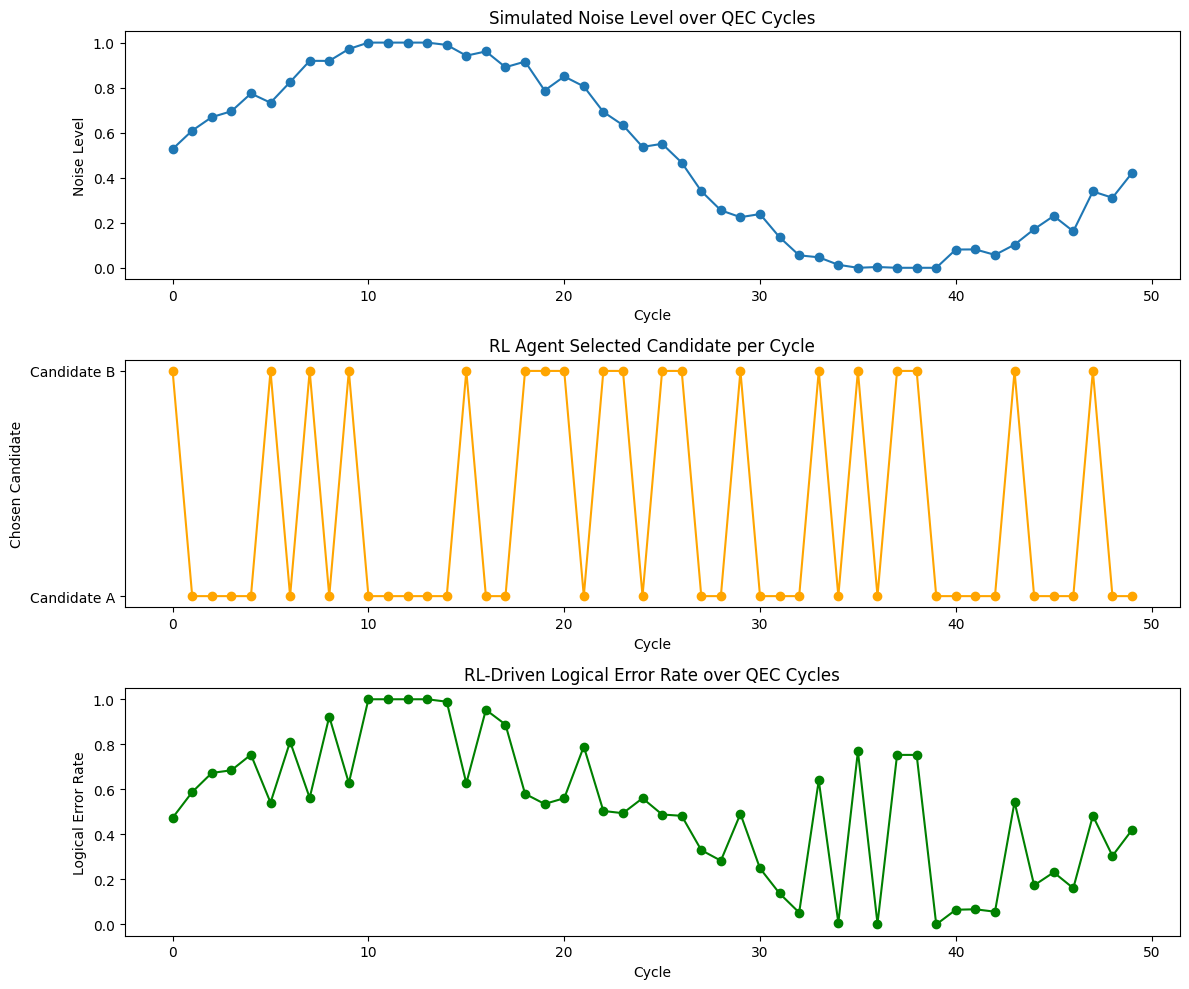

In [26]:
cycles = np.arange(num_cycles)
# Map candidate choices to numeric values for plotting: Candidate A -> 0, Candidate B -> 1.
candidate_numeric = [0 if x == "A" else 1 for x in rl_chosen_candidates]

plt.figure(figsize=(12, 10))

plt.subplot(3,1,1)
plt.plot(cycles, rl_noise_levels, marker='o')
plt.xlabel("Cycle")
plt.ylabel("Noise Level")
plt.title("Simulated Noise Level over QEC Cycles")

plt.subplot(3,1,2)
plt.plot(cycles, candidate_numeric, marker='o', color='orange')
plt.yticks([0, 1], ['Candidate A', 'Candidate B'])
plt.xlabel("Cycle")
plt.ylabel("Chosen Candidate")
plt.title("RL Agent Selected Candidate per Cycle")

plt.subplot(3,1,3)
plt.plot(cycles, rl_error_rates, marker='o', color='green')
plt.xlabel("Cycle")
plt.ylabel("Logical Error Rate")
plt.title("RL-Driven Logical Error Rate over QEC Cycles")

plt.tight_layout()
plt.show()
